In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [163]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random
from src.utils import create_2d_mask
from src.interpolate import *

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale


In [127]:
def get_fwd_model(pts, rotate_and_project, args = {}):
    
    @jax.jit
    def fwd_model(amp, theta):
        proj, _, _ = rotate_and_project(amp, theta, pts, **args)
        return proj
    
    fwd_model_vmap = jax.jit(jax.vmap(fwd_model, in_axes = (None, 0)))
    
    return fwd_model, fwd_model_vmap

def get_loss_function(fwd_model_vmap, thetas, data):
    
    @jax.jit
    def loss_func(amp): 
        err = fwd_model_vmap(amp, thetas) - data
        return 1/2 * jnp.sum(jnp.real(jnp.conj(err)*err)) / jnp.prod(jnp.array(err.shape))
    
    grad_loss_func = jax.jit(jax.grad(loss_func))
    
    return loss_func, grad_loss_func

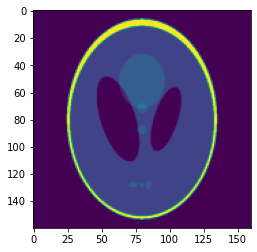

In [164]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

plt.imshow(image)

(160, 162)


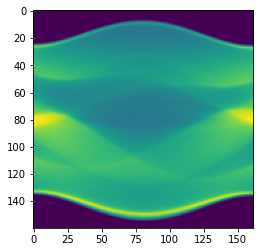

In [186]:
theta = jnp.linspace(0, 180, max(image.shape)+2)

sinogram = radon(image, theta = theta)
print(sinogram.shape)
plt.imshow(sinogram)

### GMM

In [4]:
def gen_gauss_x(amp, centre, x, sig):
    return amp * jnp.exp(-(x-centre)**2/(2*sig**2))

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, 0, None,None))

def pts2img(amp, pts, x_grid, sig):
    p_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig)
    p_y = gen_gauss_x_vmap(jnp.ones(amp.shape), pts[:,1], x_grid, sig) 
    return jnp.matmul(p_x.transpose(), p_y).transpose() 

#pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)


def rotate_and_project_gmm(amp, theta, pts, x_grid, sig):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts = (R @ pts.transpose()).transpose()
    img = pts2img(amp, pts, x_grid, sig)
    proj = jnp.sum(img, axis=0)
    
    return proj, img, pts

In [166]:
nx = 32
x_grid = jnp.fft.fftshift(jnp.fft.fftfreq(nx))
sigma = 0.02
amp = 10 + jnp.array(np.random.randn(nx*nx))

rotate_and_project_args = {"x_grid" : x_grid, "sig" : sigma }

In [167]:
X, Y = jnp.meshgrid(x_grid, x_grid)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

In [168]:
grid_obj = np.array([x_grid[1]-x_grid[0], nx])
mask = jnp.fft.fftshift(create_2d_mask(grid_obj, (0,0), 0.45))

In [169]:
img = pts2img(amp, pts, x_grid, sigma)

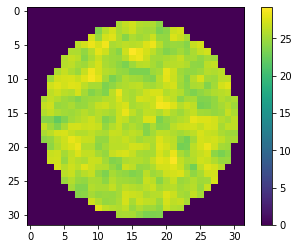

In [170]:
plt.imshow(img*mask); plt.colorbar()

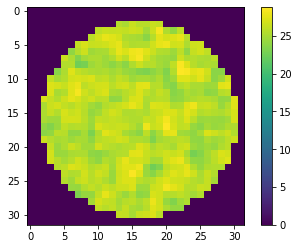

In [171]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project_gmm(amp, theta, pts, x_grid, sigma)
plt.imshow(mask*img_rot); plt.colorbar()

In [187]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_gmm, rotate_and_project_args)

N = 34
sig_noise = 1000

thetas = jnp.linspace(0., 2*jnp.pi, N)

data = fwd_model_vmap(amp, thetas) 
data_noisy = data + np.random.randn(N, nx) * sig_noise

SNR = jnp.sum(data**2)/jnp.sum(data_noisy**2)
print(f"max(data) = {jnp.max(data)}")
print(f"SNR = {SNR}")

max(data) = 843.1538667806952
SNR = 0.33576108428932616


In [188]:
sinogram.shape

(160, 162)

In [189]:
data.shape

(34, 32)

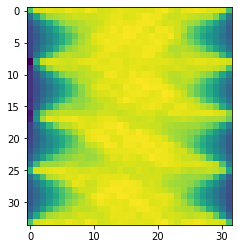

In [190]:
plt.imshow(data)

In [173]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap, thetas, data)

N_iters = 100
alpha = 2e-1

x0 = jnp.zeros(amp.shape)

for i in range(N_iters):
    if jnp.mod(i, 10) == 0:
        err = jnp.abs(amp-x0).reshape([nx,nx]) * mask

        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad_loss_func(x0)

258.0555053320982
26.615643719887093
24.039823446340364


KeyboardInterrupt: 

19.38007636843135


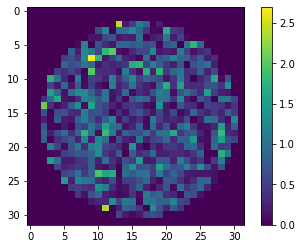

In [14]:
err = jnp.abs(amp-x0).reshape([nx,nx]) * mask
plt.imshow(err); plt.colorbar()
print(jnp.sqrt(jnp.sum(err**2)))

In [15]:
img_rec = pts2img(x0, pts, x_grid, sigma)

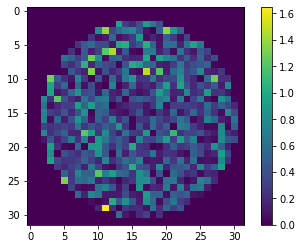

In [16]:
plt.imshow(jnp.abs(img_rec-img)*mask); plt.colorbar()

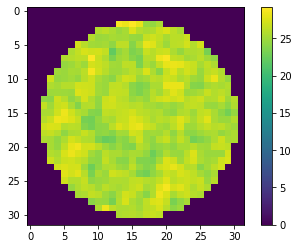

In [17]:
plt.imshow(img*mask); plt.colorbar()

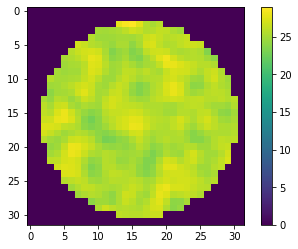

In [18]:
plt.imshow(img_rec*mask); plt.colorbar()

### Fourier

In [19]:
img_f = jnp.fft.fft2(jnp.fft.ifftshift(img)) #*jnp.fft.fftshift(mask)
#img_f = img_f.at[0,0].set(0) # 

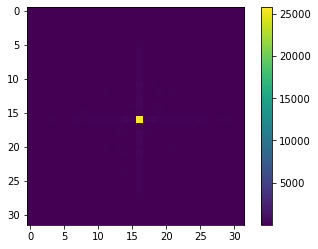

In [20]:
plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar()

In [135]:
def rotate_and_project_f(img_f, theta, pts):
    """pts are the Fourier grid points, img_f is the image in Fourier, flattened"""
    
    nx = img_f.shape[0]

    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts_rot = R @ pts.transpose()
    pts_rot = jnp.vstack([pts_rot, jnp.zeros((1,nx*nx))])
    x_grid = np.array([1.0, nx])
    
    idx0 = nx*int(nx/2)
    vol = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

    vol = vol.at[:,:,int(nx/2)].set(jnp.fft.fftshift(img_f))
    vol = jnp.fft.ifftshift(vol)
    img = interpolate(pts_rot, x_grid, vol, 'tri')
    
    #print(pts[idx0:idx0+nx,:])

    proj = img[idx0:idx0+nx]
    
    return proj, img, pts

In [103]:
# Get the Fourier grid
x_grid_f = jnp.arange(-nx/2, nx/2)
X, Y = jnp.meshgrid(x_grid_f, x_grid_f)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

32


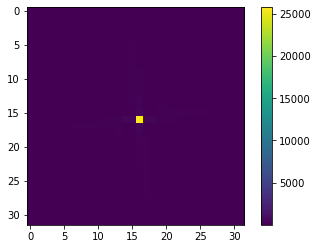

In [115]:
theta = jnp.pi/32
proj, img_rot, pts_rot = rotate_and_project_f(img_f, theta, pts)

plt.imshow((jnp.abs(img_rot.reshape([nx,nx])))); plt.colorbar()

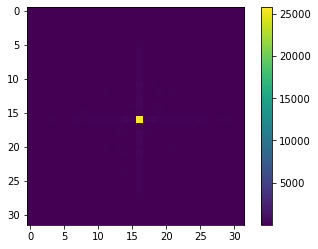

In [116]:
plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar()

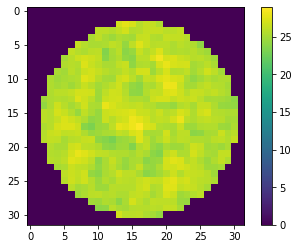

In [117]:
img_rot_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(img_rot.reshape([nx,nx])))))
plt.imshow(img_rot_r*mask); plt.colorbar()

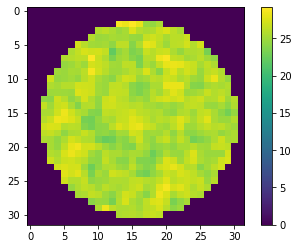

In [118]:
plt.imshow(img*mask); plt.colorbar()

In [128]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_f)

N = 1000
sig_noise = 10000

thetas = 2 * jnp.pi * jnp.array(np.random.rand(N)) 

data = fwd_model_vmap(img_f, thetas) 
data_noisy = data + (np.random.randn(N, nx) + 1j*np.random.randn(N, nx))* sig_noise

SNR = jnp.real(jnp.sum(jnp.conj(data)*data)/jnp.sum(jnp.conj(data_noisy)*data_noisy))
print(f"max(data) = {jnp.max(jnp.abs(data))}")
print(f"SNR = {SNR}")

32
max(data) = 25743.85697818961
SNR = 0.09309517405445825


In [132]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap, thetas, data)

In [146]:
N_iters = 100
alpha = 1e-2

x0 = jnp.zeros(img_f.shape, dtype = jnp.complex128)
x0 = img_f + 1

for i in range(N_iters):
    if jnp.mod(i, 10) == 0:
        err = jnp.abs(img_f-x0).reshape([nx,nx]) * mask

        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad_loss_func(x0)

25.632011235952593
25.63069389414189
25.629376690507705
25.628059625036872
25.626742697716224
25.62542590853256
25.624109257472718
25.622792744523537
25.621476369671825
25.620160132904438


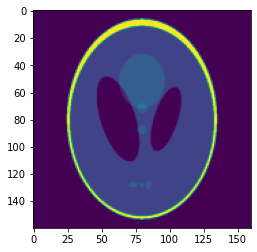

In [160]:
sinogram.shape

(400, 2)